# Term Deposit Subscription Prediction
## 🧠 Objective
This project aims to predict whether a customer will subscribe to a term deposit product, based on features from a European bank's direct marketing campaign dataset.

## 📋 Background
The marketing campaign data involves phone contacts with bank customers. Term deposits are financial products that require customers to lock in funds for a fixed period. Predicting subscription likelihood helps improve targeting strategies.

**Goal:** Build an interpretable machine learning model to classify subscription outcome (`yes`/`no`).

## Steps
classification problem = logistic regression and random forest

- 1. Read data & eda - visualize data, check dimension
- 2. EDA: visualize data, check dimensions; Feature Engineering
- 3. Split features/labels (stratify the split to keep the yes/no ratio the same in train and test)
- 4. Build the pipelines: logistic regression and random forest
- 5. Evaluate baseline performance via stratified 5-fold CV
- 6. Model valuation: cross-validation set and test set
- 7. Determine the segment(s) of customers our client should prioritize.
        - fit on full data and get predicted probabilities + default predictions
        - segment “likely yes” customers (prediction==1)    
        - rank segments by average predicted probabilities
- 8. Use feature importances & permutation importance
- 9. Compare results from this Logistic Regression model with those from Random Forest
- 10. Conclusion


## 🗂️ Data Overview
We'll start by loading the dataset, inspecting its structure, and understanding the variables.

In [18]:
import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.inspection import permutation_importance

%matplotlib inline

In [19]:
# EDA
# 1. read the file as a DataFrame
df = pd.read_csv("term-deposit-marketing-2020.csv")
print((list(df.columns)))

['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'y']


In [20]:
# split into features (X) and target (Y)
x_ = df[['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign']].copy()
y_ = df['y'].copy()

# quick sanity‑check
print("x_ shape:", x_.shape)
print("y_ shape:", y_.shape)

x_ shape: (40000, 13)
y_ shape: (40000,)


In [21]:
print("First five elements in X_ are:\n", x_[:5])
print("Type of X_:",type(x_))

First five elements in X_ are:
    age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  
0  unknown    5   may       261         1  
1  unknown    5   may       151         1  
2  unknown    5   may        76         1  
3  unknown    5   may        92         1  
4  unknown    5   may       198         1  
Type of X_: <class 'pandas.core.frame.DataFrame'>


In [22]:
print("First five elements in y_ are:\n", y_[:5])
print("Type of y_:",type(y_))

First five elements in y_ are:
 0    no
1    no
2    no
3    no
4    no
Name: y, dtype: object
Type of y_: <class 'pandas.core.series.Series'>


In [23]:
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64


In [24]:
print("\nNumeric summary:")
print(df.describe())


Numeric summary:
                age        balance           day      duration      campaign
count  40000.000000   40000.000000  40000.000000  40000.000000  40000.000000
mean      40.544600    1274.277550     16.017225    254.824300      2.882175
std        9.641776    2903.769716      8.278127    259.366498      3.239051
min       19.000000   -8019.000000      1.000000      0.000000      1.000000
25%       33.000000      54.000000      8.000000    100.000000      1.000000
50%       39.000000     407.000000     17.000000    175.000000      2.000000
75%       48.000000    1319.000000     21.000000    313.000000      3.000000
max       95.000000  102127.000000     31.000000   4918.000000     63.000000


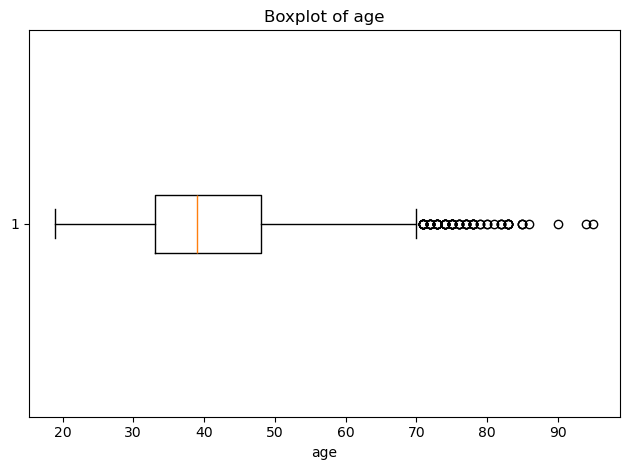

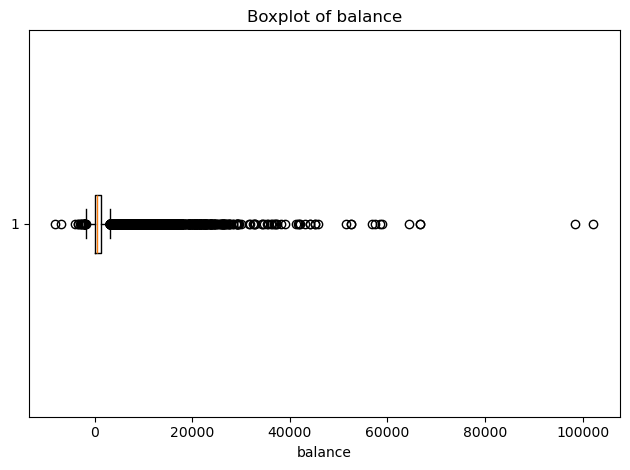

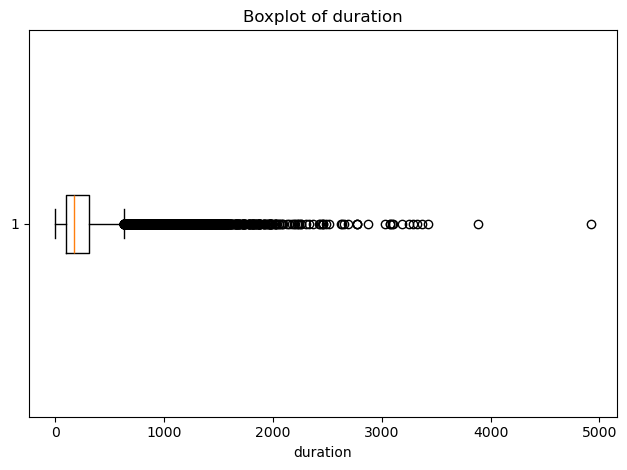

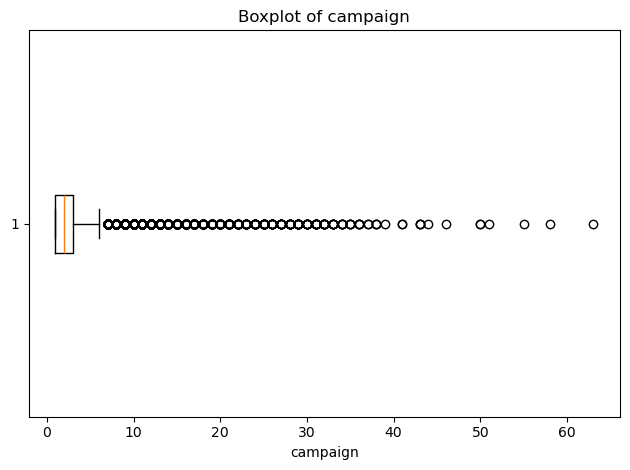

In [25]:
# Boxplots to spot outliers
numeric_cols = ['age','balance','duration','campaign']
for col in numeric_cols:
    plt.figure()
    plt.boxplot(df[col].dropna(), vert=False)
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.tight_layout()

In [26]:
# Categorical counts
for col in ['job','marital','education','default','housing','loan','contact','y']:
    counts = df[col].value_counts()
    print(f"\n{col} value counts:")
    print(counts)


job value counts:
job
blue-collar      9383
management       8166
technician       6852
admin            4483
services         3910
retired          1437
self-employed    1414
entrepreneur     1405
unemployed       1104
housemaid        1087
student           524
unknown           235
Name: count, dtype: int64

marital value counts:
marital
married     24386
single      10889
divorced     4725
Name: count, dtype: int64

education value counts:
education
secondary    20993
tertiary     11206
primary       6270
unknown       1531
Name: count, dtype: int64

default value counts:
default
no     39191
yes      809
Name: count, dtype: int64

housing value counts:
housing
yes    24031
no     15969
Name: count, dtype: int64

loan value counts:
loan
no     33070
yes     6930
Name: count, dtype: int64

contact value counts:
contact
cellular     24914
unknown      12765
telephone     2321
Name: count, dtype: int64

y value counts:
y
no     37104
yes     2896
Name: count, dtype: int64


## 📊 Exploratory Data Analysis
Visualize class imbalance and distributions to detect skew, outliers, or trends.

### Visualize data, 
- check whether the target is skewed
- histograms of each feature
- boxplot of each feature by target class


Text(0, 0.5, 'Count')

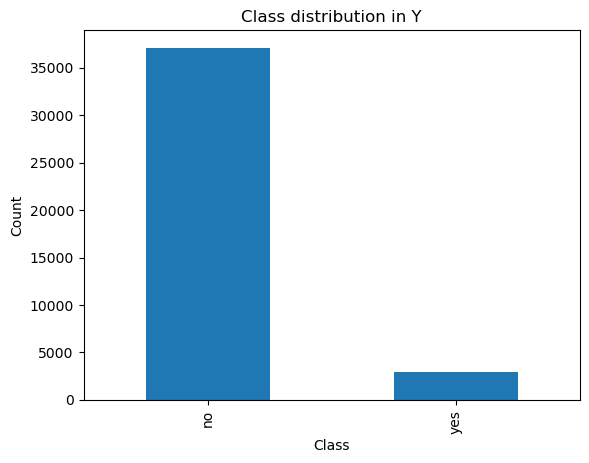

In [29]:
y_.value_counts().plot(kind="bar")
plt.title("Class distribution in Y"); plt.xlabel("Class"); plt.ylabel("Count")


Text(0.5, 1.02, 'Histograms of the numeric features')

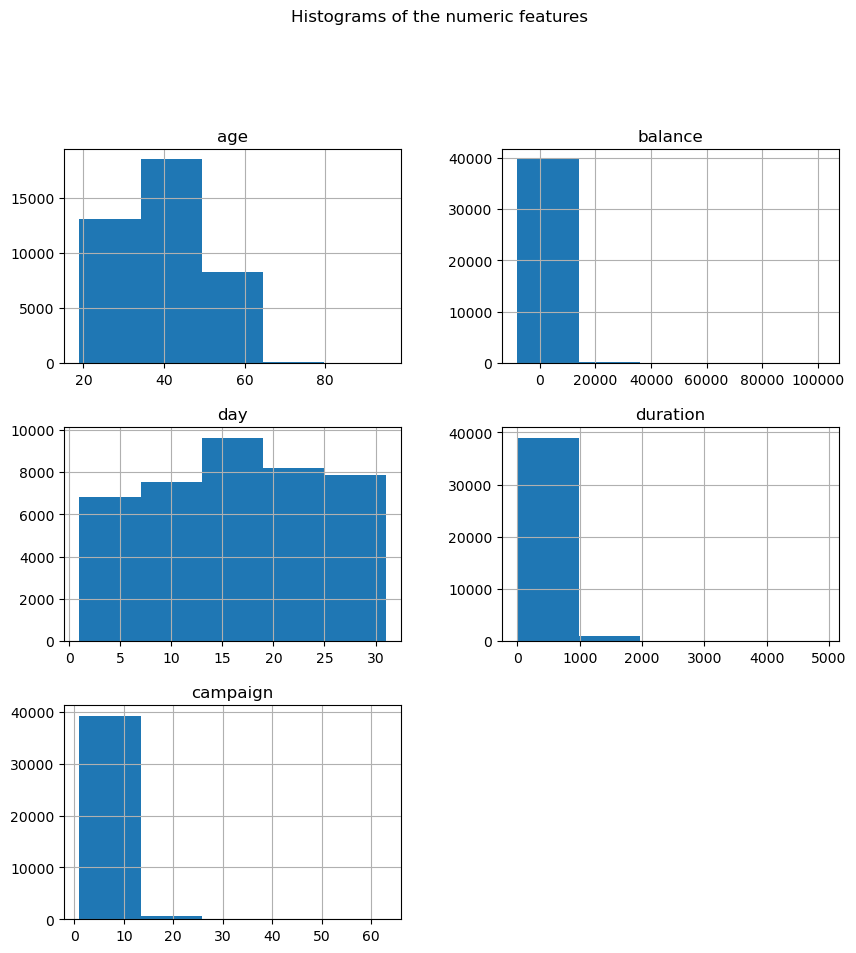

In [30]:
x_.hist(figsize=(10,10), bins=5)
plt.suptitle("Histograms of the numeric features", y=1.02)


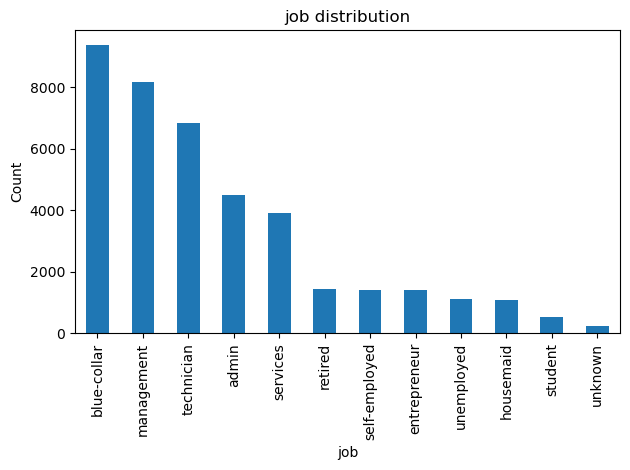

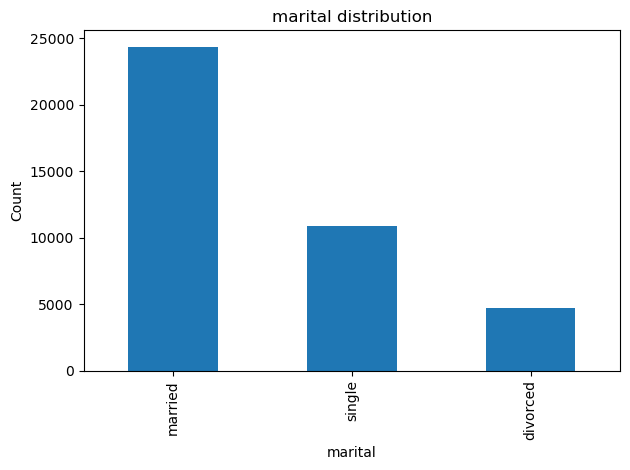

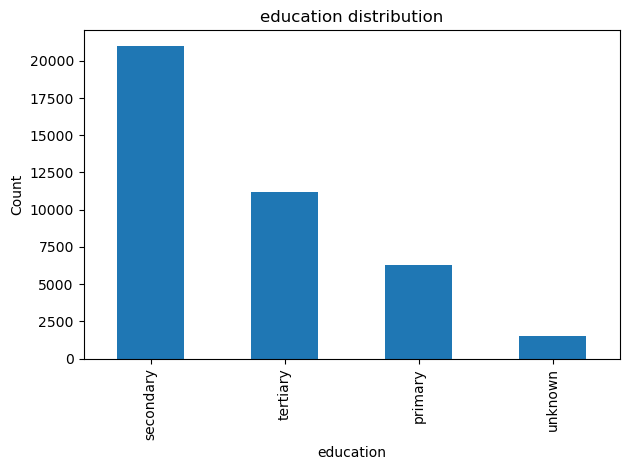

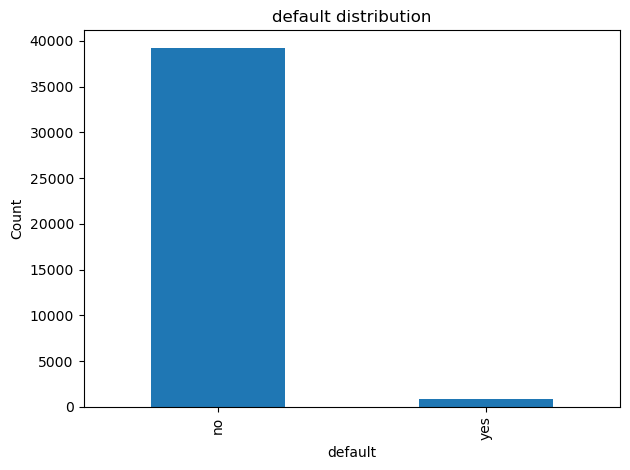

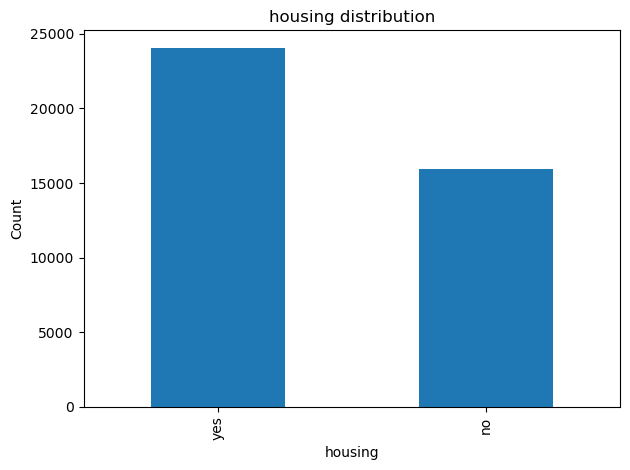

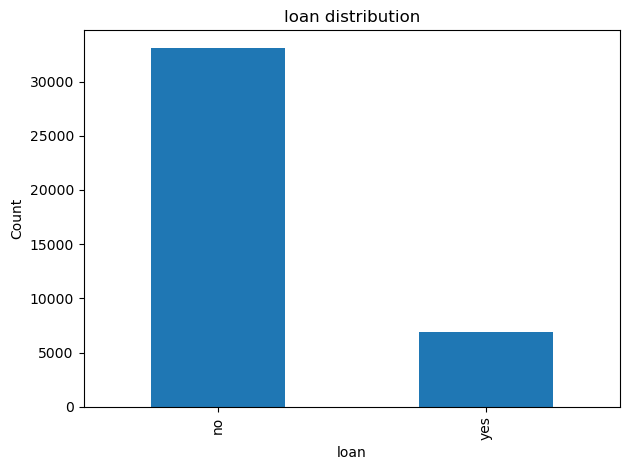

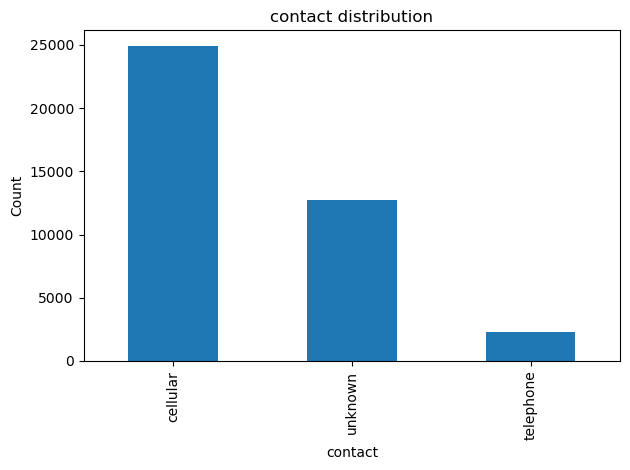

In [31]:
# Bar‐plots for categorical variables
for col in ['job','marital','education','default','housing','loan','contact']:
    plt.figure()
    df[col].value_counts().plot(kind='bar')
    plt.title(f'{col} distribution')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()

## 🧹 Feature Engineering & Preprocessing
We'll encode categorical variables, handle missing values, and prepare the feature matrix for modeling.

In [33]:
# 3a) Identify columns; map yes, no in y to 1,0
y_ = df["y"].map({"no": 0, "yes": 1})


numeric_cols = ["age", "balance", "day", "duration", "campaign"]
categorical_cols = ["job", "marital", "education", "default", "housing", "loan", "contact", "month"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
])
#with scaling, the numeric features enter the model with mean 0 and variance 1, 
#ensuring fair regularization and more reliable convergence—typically boosting both accuracy and minority-class recall.

In [34]:
# 3b). Split features/labels: train, cross validation and test sets

# Get 60% of the dataset as the training set. Put the remaining 40% in temporary variables.
x_bc_train, x__, y_bc_train, y__ = train_test_split(x_, y_, test_size=0.40, random_state=1)

# Split the 40% subset above into two: one half for cross validation and the other for the test set
x_bc_cv, x_bc_test, y_bc_cv, y_bc_test = train_test_split(x__, y__, test_size=0.50, random_state=1)

# Delete temporary variables
del x__, y__

print(f"the shape of the training set (input) is: {x_bc_train.shape}")
print(f"the shape of the training set (target) is: {y_bc_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {x_bc_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_bc_cv.shape}\n")
print(f"the shape of the test set (input) is: {x_bc_test.shape}")
print(f"the shape of the test set (target) is: {y_bc_test.shape}")

the shape of the training set (input) is: (24000, 13)
the shape of the training set (target) is: (24000,)

the shape of the cross validation set (input) is: (8000, 13)
the shape of the cross validation set (target) is: (8000,)

the shape of the test set (input) is: (8000, 13)
the shape of the test set (target) is: (8000,)


In [35]:
#4. Build a pipeline: LogisticRegression
model = Pipeline([
    ("pre", preprocessor),
    ("clf", LogisticRegression(
        solver='liblinear',
        class_weight='balanced', 
        max_iter=10000))
    ])

#class_weight='balanced': automatically reweights the minority class higher to combat imbalance.

#5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, x_bc_train, y_bc_train, cv=cv, scoring='accuracy')
print(f"5‐fold CV accuracy (balanced LR): {cv_scores.mean():.4f}")


5‐fold CV accuracy (balanced LR): 0.8666


In [36]:
model.fit(x_bc_train, y_bc_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'balance', 'day',
                                                   'duration', 'campaign']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=10000,
                                    solver='liblinear'))])

In [37]:
# 5. Model valuation: cross-validation set

pred = model.predict(x_bc_cv)

print(f"\nHold‑out accuracy: {accuracy_score(y_bc_cv, pred):.3%}")
print("\nConfusion matrix:\n", confusion_matrix(y_bc_cv, pred))
print("\nClassification report:\n", classification_report(y_bc_cv, pred, digits=3))


Hold‑out accuracy: 87.338%

Confusion matrix:
 [[6521  933]
 [  80  466]]

Classification report:
               precision    recall  f1-score   support

           0      0.988     0.875     0.928      7454
           1      0.333     0.853     0.479       546

    accuracy                          0.873      8000
   macro avg      0.660     0.864     0.704      8000
weighted avg      0.943     0.873     0.897      8000



In [38]:
# Model valuation: test set

pred_test = model.predict(x_bc_test)

print(f"\nHold‑out accuracy: {accuracy_score(y_bc_test, pred_test):.3%}")
print("\nConfusion matrix:\n", confusion_matrix(y_bc_test, pred_test))
print("\nClassification report:\n", classification_report(y_bc_test, pred_test, digits=3))


Hold‑out accuracy: 86.875%

Confusion matrix:
 [[6442  983]
 [  67  508]]

Classification report:
               precision    recall  f1-score   support

           0      0.990     0.868     0.925      7425
           1      0.341     0.883     0.492       575

    accuracy                          0.869      8000
   macro avg      0.665     0.876     0.708      8000
weighted avg      0.943     0.869     0.894      8000



In [39]:
# 7a) Fit on full data and get predicted probabilities + default predictions
model.fit(x_, y_)
probs = model.predict_proba(x_)[:, 1]
preds = (probs >= 0.5).astype(int)  # default threshold = 0.5

# b. Segment “likely yes” customers (pred == 1)
seg = df[preds == 1].copy()
seg['pred_prob'] = probs[preds == 1]

# c. Rank segments by average predicted probability
for col in ['job', 'education', 'marital']:
    grouping = (
        seg.groupby(col)['pred_prob']
           .agg(['count', 'mean'])
           .sort_values('mean', ascending=False)
           .head(5)
    )
    print(f"\nTop 5 segments by {col}:")
    display(grouping)


Top 5 segments by job:


,count,mean
job,,
housemaid,123,0.827778
self-employed,270,0.801259
unemployed,272,0.792827
management,1669,0.789169
technician,1239,0.788750



Top 5 segments by education:


,count,mean
education,,
primary,867,0.792834
unknown,265,0.790480
tertiary,2554,0.790243
secondary,3704,0.781585



Top 5 segments by marital:


,count,mean
marital,,
divorced,925,0.794550
married,3813,0.785743
single,2652,0.783990



Top 10 Features by Permutation Importance (drop in Accuracy):
 feature  mean_importance  std_importance
duration         0.073587        0.002121
   month         0.042750        0.002721
 contact         0.030775        0.002019
     day         0.009012        0.001406
 housing         0.005762        0.001253
    loan         0.001662        0.000891
 default         0.000425        0.000245
 marital         0.000375        0.000740
     job        -0.000238        0.000876
 balance        -0.000263        0.000469


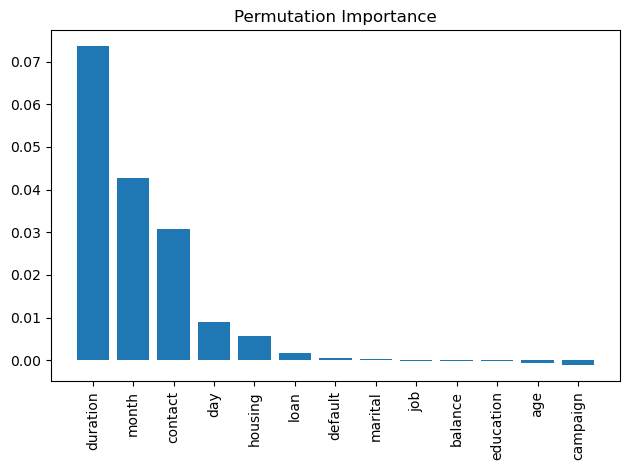

In [69]:
# 8. Permutation Importance
perm_imp = permutation_importance(
    estimator=model,
    X=x_bc_test,
    y=y_bc_test,
    n_repeats=10,
    random_state=42,
    scoring='accuracy'
)

# ORGANIZE RESULTS INTO A DATAFRAME 
# `importances_mean` and `importances_std` are arrays of length = number of original features.
feature_names = x_bc_test.columns.tolist()
imp_df = pd.DataFrame({
    'feature'         : feature_names,
    'mean_importance' : perm_imp.importances_mean,
    'std_importance'  : perm_imp.importances_std
})

# Sort descending by mean_importance
imp_df = imp_df.sort_values(by='mean_importance', ascending=False)

# DISPLAY TOP 10 FEATURES BY PERMUTATION IMPORTANCE 
top10 = imp_df.head(10).reset_index(drop=True)
print("\nTop 10 Features by Permutation Importance (drop in Accuracy):")
print(top10.to_string(index=False))

# Plot
plt.figure()
plt.bar(imp_df['feature'], imp_df['mean_importance'])
plt.xticks(rotation=90)
plt.title("Permutation Importance")
plt.tight_layout()
plt.show()


Top 10 Features by Permutation Importance (drop in Accuracy):
  feature  mean_importance  std_importance
 duration         0.555478        0.006232
    month         0.127130        0.004565
  contact         0.095304        0.013756
  housing         0.042609        0.005289
  marital         0.008870        0.003517
     loan         0.007130        0.004947
      job         0.004870        0.003281
education         0.004696        0.005771
 campaign         0.004174        0.002603
  balance         0.002261        0.001358


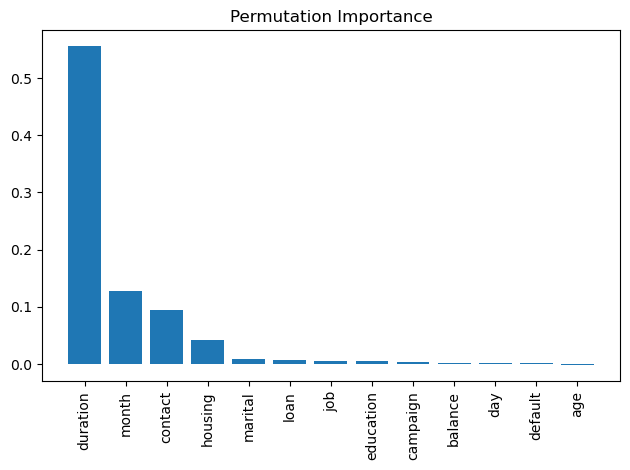

In [41]:
perm_imp = permutation_importance(
    estimator=model,
    X=x_bc_test,
    y=y_bc_test,
    n_repeats=10,
    random_state=42,
    scoring='recall'
)

# ORGANIZE RESULTS INTO A DATAFRAME
# `importances_mean` and `importances_std` are arrays of length = number of original features.
feature_names = x_bc_test.columns.tolist()
imp_df = pd.DataFrame({
    'feature'         : feature_names,
    'mean_importance' : perm_imp.importances_mean,
    'std_importance'  : perm_imp.importances_std
})

# Sort descending by mean_importance
imp_df = imp_df.sort_values(by='mean_importance', ascending=False)

# DISPLAY TOP 10 FEATURES BY PERMUTATION IMPORTANCE
top10 = imp_df.head(10).reset_index(drop=True)
print("\nTop 10 Features by Permutation Importance (drop in Accuracy):")
print(top10.to_string(index=False))

# Plot
plt.figure()
plt.bar(imp_df['feature'], imp_df['mean_importance'])
plt.xticks(rotation=90)
plt.title("Permutation Importance")
plt.tight_layout()
plt.show()


Top 10 Features by Permutation Importance (drop in Accuracy):
  feature  mean_importance  std_importance
 duration         0.303877        0.003734
    month         0.107004        0.004525
  contact         0.080129        0.005522
  housing         0.022996        0.003266
      day         0.017000        0.003149
     loan         0.005158        0.002727
  marital         0.003222        0.001881
  default         0.001101        0.000537
      job         0.000920        0.002137
education         0.000755        0.002871


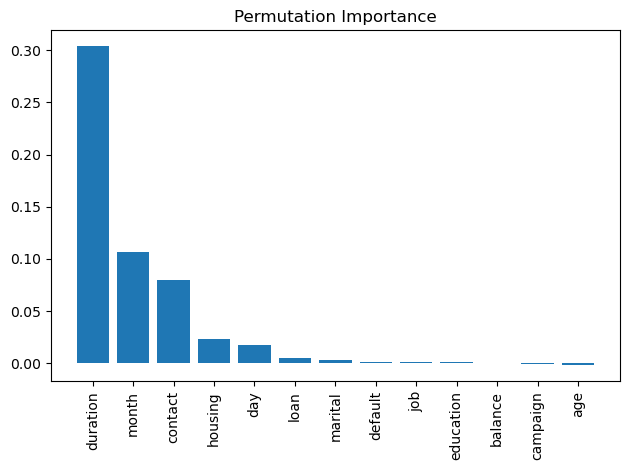

In [42]:
perm_imp = permutation_importance(
    estimator=model,
    X=x_bc_test,
    y=y_bc_test,
    n_repeats=10,
    random_state=42,
    scoring='f1'
)

# ORGANIZE RESULTS INTO A DATAFRAME
# `importances_mean` and `importances_std` are arrays of length = number of original features.
feature_names = x_bc_test.columns.tolist()
imp_df = pd.DataFrame({
    'feature'         : feature_names,
    'mean_importance' : perm_imp.importances_mean,
    'std_importance'  : perm_imp.importances_std
})

# Sort descending by mean_importance
imp_df = imp_df.sort_values(by='mean_importance', ascending=False)

# DISPLAY TOP 10 FEATURES BY PERMUTATION IMPORTANCE
top10 = imp_df.head(10).reset_index(drop=True)
print("\nTop 10 Features by Permutation Importance (drop in Accuracy):")
print(top10.to_string(index=False))

# Plot
plt.figure()
plt.bar(imp_df['feature'], imp_df['mean_importance'])
plt.xticks(rotation=90)
plt.title("Permutation Importance")
plt.tight_layout()
plt.show()

### Observations:
#### EDA
- Y column skewed (the target y contains more 'no' and 'yes' values. Therefore, the data is imbalanced.
- X columns are a combination of numerical and categorical columns.
- No missing values.
- 3 top jobs: blue collar, management, technician.

The Logistic Regression method seems to fit the model well. I also plan to fit the data using the Random Forest Model. It's essential to note that the data is limited, with a high ratio of 'No' versus 'Yes', which impacted the results, particularly recall.

To improve recall, the following was included:
- a standard scaler for the numerical columns.
- StratifiedKFold in the built-on-the- the fly cross validation.
- class_weight='balanced' in the model. This automatically reweights the minority class higher to combat imbalance.

This improved the result. The 5-fold CV accuracy (balanced LR) achieves a score of 86.7%. This exceeds the 81% specified in the requirements. Additionally, the hold-out accuracy for the model is 87.3 on the CV dataset and 86.9 on the test dataset. Observation: The model achieves a high recall (85%), but its precision (33%) and F1 score (48%) are low for the minority class. We may need to apply the SMOTE technique to address the imbalance in the dataset.

Determine the segment(s) of customers our client should prioritize.
 
- Top 5 segments by job: housemaid, self-employed, unemployed, management, technician.
- Top 5 segments by education: primary, unknown, tertiary, secondary.
- Top 5 segments by marital status: divorced, married, single.
The results from the permutation importance indicate that the fop feature to focus on is the “last contact duration.

### Other observations
Results from the Random Forest Model (not included in this notebook) indicate a higher precision (60%) score for the minority class, but a significantly lower recall (15%) and F-score (25%). The choice of whether to prioritize recall or precision depends on the cost per contact and the value of a converted subscriber. If the cost per customer is similar to or exceeds the value a converted subscriber brings, then precision should be prioritized.

The Top 5 segments by job are different for the RF model compared to what the LR model suggested. 
- Top 5 segments by job: retired, management, services, student, technician.
- Top 5 segments by education: tertiary, secondary, primary,  unknown.
- Top 5 segments by marital status:  single, divorced, married.

The results from the permutation importance indicate that the feature to focus on is the “last contact duration."



## 🧾 Conclusion
- Built a classification model using cleaned campaign data.
- Investigated features influencing term deposit subscription.
    - The key feature to focus on is the “last contact duration.
- Next steps: hyperparameter tuning, A/B testing on live campaigns.